In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in data into 
schedule=pd.read_excel('../data/Marshall_Course_Enrollment_1516_1617.xlsx') # last two years of schedules at Marshall
capacities=pd.read_excel('../data/Marshall_Room_Capacity_Chart.xlsx') # rooms within marshall

# combine datasets with key 'First Room' for schedule and key 'Room' for capacities
data = (pd.merge(schedule, capacities, how = 'left', left_on= 'First Room', right_on='Room')
       [['Term','Section','Department','First Begin Time','First Days','First End Time','First Room',
         'Reg Count','Size']]
       )

# filter out courses which were not held in rooms within Marshall
data = data[data['Size'].notnull()]

# rename columns
data = data.rename(columns={'First Begin Time':'Begin','First Days':'Days',
                            'First End Time':'End','First Room':'Room','Reg Count':'Registered'})
data.tail()

,Term,Section,Department,Begin,Days,End,Room,Registered,Size
2894,20172,66746,BUCO,12:00:00,MW,14:20:00,JFF312,17,20.0
2895,20172,66763,BUCO,15:00:00,TH,17:20:00,JFF327,17,36.0
2896,20172,66757,BUCO,09:00:00,TH,11:20:00,JFF313,18,20.0
2897,20172,66742,BUCO,09:00:00,MW,11:20:00,JFF313,16,20.0
2898,20172,66750,BUCO,15:00:00,MW,17:20:00,JFF313,19,20.0


In [199]:
# define a function to convert time
def convert(inputTime):
    # define convert function
    try:
        hh,mm,ss=str(inputTime).split(':')
        ans=int(hh)+int(mm)/60+int(ss)/3600
    except:
        ans=np.nan
    return ans

In [200]:
# apply the convert function to begin time
data['Begin'] = data['Begin'].apply(convert)

In [201]:
# apply the convert function to end time
data['End'] = data['End'].apply(convert)

In [202]:
data.tail()

,Term,Section,Department,Begin,Days,End,Room,Registered,Size
2894,20172,66746,BUCO,12.0,MW,14.333333,JFF312,17,20.0
2895,20172,66763,BUCO,15.0,TH,17.333333,JFF327,17,36.0
2896,20172,66757,BUCO,9.0,TH,11.333333,JFF313,18,20.0
2897,20172,66742,BUCO,9.0,MW,11.333333,JFF313,16,20.0
2898,20172,66750,BUCO,15.0,MW,17.333333,JFF313,19,20.0


In [211]:
depts = ['BUCO','DSO','FBE','ACCT','MKT','BAEP','MOR']

In [215]:
# filter out courses that were not held within prime time (10:00 - 16:00)
dataTimeClean = data.drop(data[(data.Begin < float(10)) | (data.End > float(16))].index)
dataTimeClean.tail()

,Term,Section,Department,Begin,Days,End,Room,Registered,Size
2827,20172,15595,ACCT,13.0,MW,15.416667,JKP202,39,54.0
2828,20172,15599,FBE,13.0,MW,15.416667,JKP110,35,77.0
2845,20172,15845,FBE,13.0,TH,15.416667,JKP110,40,77.0
2893,20172,66761,BUCO,12.0,TH,14.333333,JFF312,16,20.0
2894,20172,66746,BUCO,12.0,MW,14.333333,JFF312,17,20.0


In [205]:
# check the number of observations after filtering
print("Original data size:", data.shape)
print("Data size after filtering prime time:", dataTimeClean.shape)

Original data size: (1921, 9)
Data size after filtering prime time: (864, 9)


In [206]:
# define a dictionary for the dataframe aggregation
aggregations = {
    'Registered':'sum',
    'Size': 'sum'
}

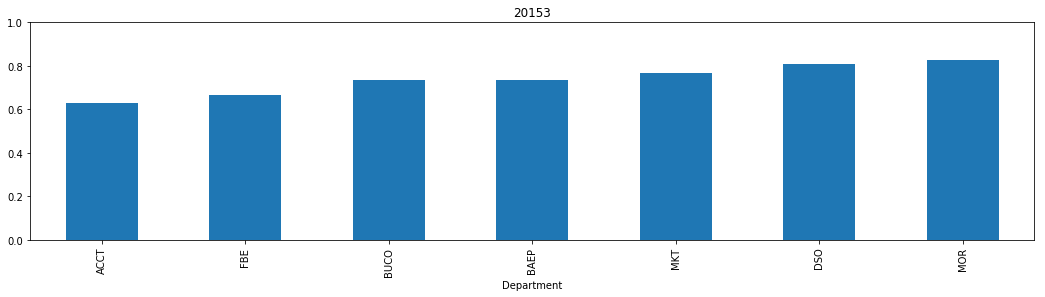

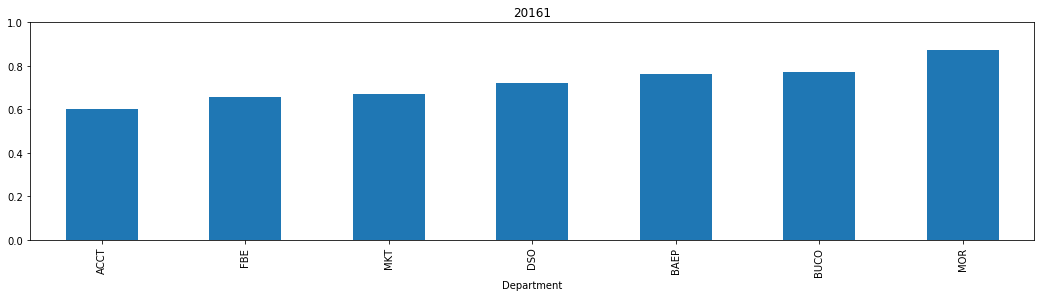

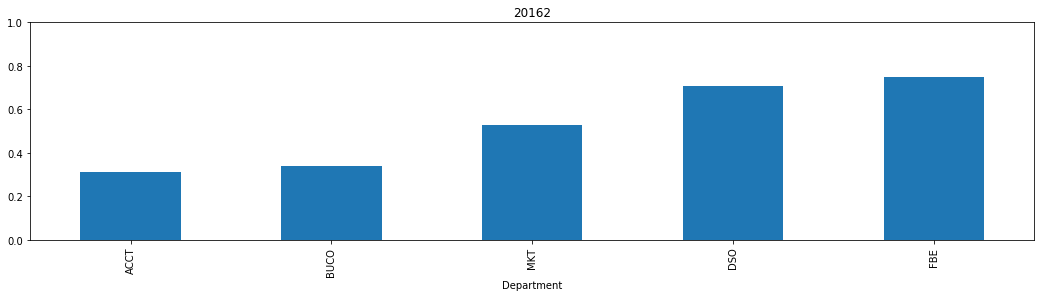

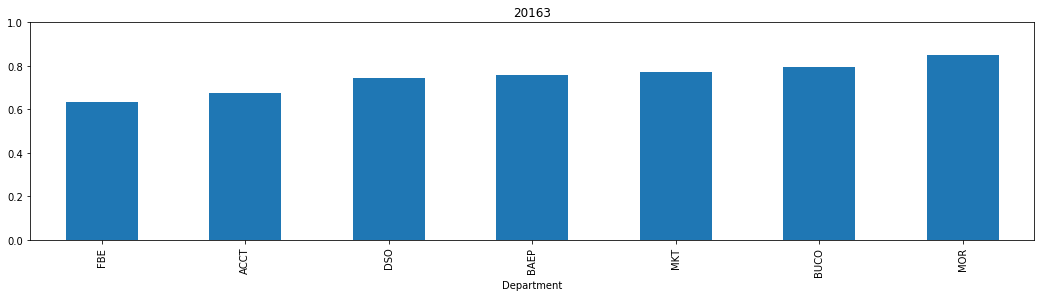

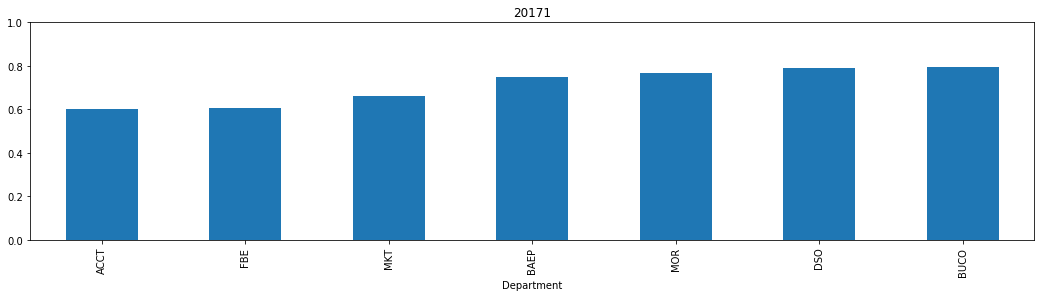

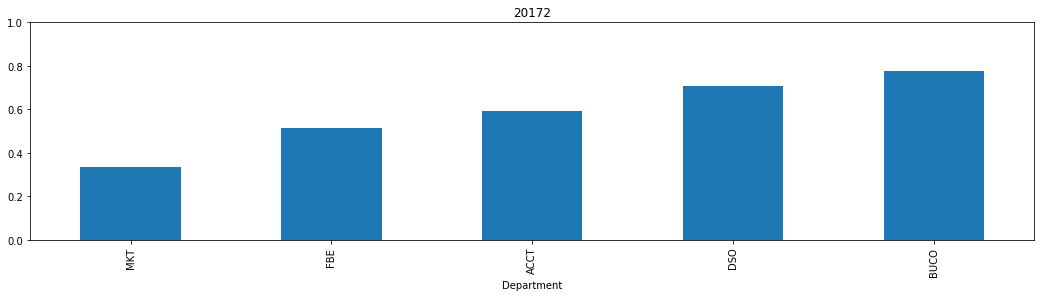

In [207]:
output = dataTimeClean

# iterate through terms and calculate utilization
# Utilization = the number of enrolled students (after add-drop date) / number of seats available
# the output is grouped by Department and terms

for term in [20153,20161,20162,20163,20171,20172]:
        (output.query("Term==@term & Department in @depts")
         .groupby('Department').agg(aggregations)
         .assign(Utilization=lambda output: output.Registered/output.Size)
         .reset_index(level=['Department'])
         .sort_values(['Utilization'])
         .plot(x='Department',y='Utilization',kind='bar', title='{0}'.format(term),figsize=(18,4),ylim=(0,1),legend=False)
        )
        
plt.show()

In [216]:
# Average Seats Utilization for all Marshall controlled classrooms
Marshall = output.query("Department in @depts").agg(aggregations)
print('Average seats utilization for Marshall: {0:.2f}' .format(Marshall.Registered/Marshall.Size))

Average seats utilization for Marshall: 0.70


In [217]:
# Average Seats Utilization in each term
output.query("Department in @depts").groupby('Term').agg(aggregations).assign(Utilization=lambda output: output.Registered/output.Size)

,Registered,Size,Utilization
Term,,,
20153,7700,10738.0,0.717080
20161,7148,10399.0,0.687374
20162,349,612.0,0.570261
20163,11122,15464.0,0.719219
20171,10811,16082.0,0.672242
20172,361,620.0,0.582258


In [219]:
# Average Seats Utilization of each department
(output.query("Department in @depts")
 .groupby('Department').agg(aggregations)
 .assign(Utilization=lambda output: output.Registered/output.Size))

,Registered,Size,Utilization
Department,,,
ACCT,9708,15503.0,0.626201
BAEP,1390,1847.0,0.752572
BUCO,2226,2919.0,0.762590
DSO,5953,7776.0,0.765561
FBE,7471,11759.0,0.635343
MKT,5914,8276.0,0.714596
MOR,4829,5835.0,0.827592


In [220]:
# Pivot table
pt1 = pd.pivot_table(output.query("Department in @depts"), index = 'Department', values = 'Registered', columns = 'Term', 
               aggfunc = sum, fill_value = 0)
pt2 = pd.pivot_table(output.query("Department in @depts"), index = 'Department', values = 'Size', columns = 'Term', 
               aggfunc = sum, fill_value = 0)
pt1/pt2

Term,20153,20161,20162,20163,20171,20172
Department,,,,,,
ACCT,0.631548,0.602936,0.312500,0.673449,0.600925,0.594203
BAEP,0.735043,0.764706,NaN,0.760417,0.748188,NaN
BUCO,0.734139,0.771654,0.342105,0.796786,0.794847,0.776316
DSO,0.807345,0.723973,0.709091,0.744275,0.792160,0.705882
FBE,0.667503,0.657227,0.747525,0.632493,0.607225,0.515625
MKT,0.767059,0.672533,0.530000,0.772083,0.663931,0.333333
MOR,0.827710,0.872753,NaN,0.851108,0.767268,NaN
